In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt

np.random.seed(42)

# Подготовка данных

В качестве данных будем использовать информацию о количестве заболеваний/смертей в US:

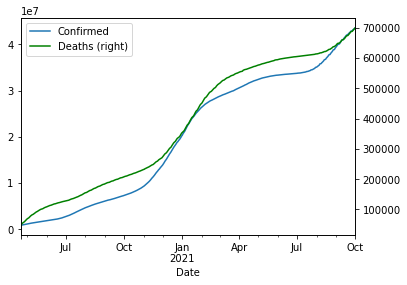

In [2]:
df = pd.read_csv('data/countries-aggregated_csv.csv',parse_dates=True,index_col=0)
df = df[df['Country'] == 'US'][['Confirmed', 'Deaths']]
df = df[90:] # слишком маленькие цифры первые 3 месяца

df['Confirmed'].plot(legend=True)
df['Deaths'].plot(secondary_y=True, style="g", legend=True);

В самих данных есть систематическая ошибка - статистика за выходные практически не обновляется и все случаи заболеваний/смертей за выходные включаются в статистику за понедельник, так устроен сбор медицинской статистики в США:

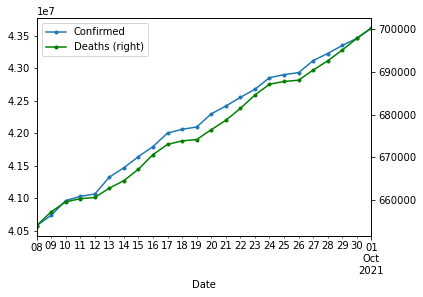

In [3]:
df['Confirmed'][-24:].plot(legend=True, style='.-')
df['Deaths'][-24:].plot(secondary_y=True, style=".-g", legend=True);

Перестроим данные, чтобы теперь для каждого дня учитывались случаи, собранные именно за прошедший день (а не куммулятивная статистика):

In [4]:
df = df - df.shift(1)
df.tail()

,Confirmed,Deaths
Date,,
2021-09-27,185016.0,2394.0
2021-09-28,109605.0,2157.0
2021-09-29,123267.0,2531.0
2021-09-30,110594.0,2728.0
2021-10-01,158284.0,2434.0


Перейдем к процентным изменениям прироста заболевших относительно предыдущего дня, не забудем выкинуть некорректные дни (понедельник, суббота, воскресенье):

In [5]:
df = df.pct_change().dropna()
df = df * 100.0
df = df[(df.index.dayofweek > 0) & (df.index.dayofweek < 5)]
df.tail(n=10)

,Confirmed,Deaths
Date,,
2021-09-16,-9.538907,27.050093
2021-09-17,34.300652,-30.724299
2021-09-21,-39.915848,-4.166667
2021-09-22,9.224983,26.132246
2021-09-23,-4.970548,13.393178
2021-09-24,41.016227,-20.455985
2021-09-28,-40.759178,-9.899749
2021-09-29,12.464760,17.338897
2021-09-30,-10.280935,7.783485


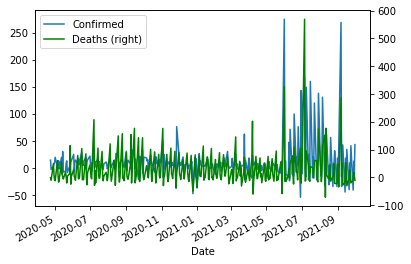

In [6]:
df['Confirmed'].plot(legend=True)
df['Deaths'].plot(secondary_y=True, style="g", legend=True);


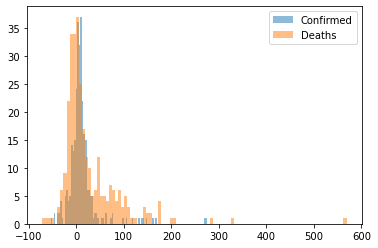

In [7]:
plt.hist(df['Confirmed'], alpha=0.5, bins=100, label='Confirmed')
plt.hist(df['Deaths'], alpha=0.5, bins=100 , label='Deaths')

plt.legend(loc='upper right')

plt.show()

# Статистическая проверка гипотез

#### О типе закона распределения

In [8]:
_, pvalue = ss.normaltest(df['Confirmed'])
pvalue

2.166394720671862e-62

In [9]:
_, pvalue = ss.normaltest(df['Deaths'])
pvalue

2.324389347534702e-59

обе выборки не принадлежат нормальному распределению ввиду очень маленького `pvalue` по тесту д'Аугустино-Пирсона

#### Об однородности двух или нескольких выборок
Сделаем две выборки - по периодам `[2020-05:2020-11]` и `[2020-11:2021-05]`

In [10]:
ss.mannwhitneyu(df['Confirmed']['2020-05-01':'2020-11-01'], df['Confirmed']['2020-11-01':'2021-05-01'])

MannwhitneyuResult(statistic=4564.0, pvalue=0.020255682639308388)

In [11]:
ss.mannwhitneyu(df['Deaths']['2020-05-01':'2020-11-01'], df['Deaths']['2020-11-01':'2021-05-01'])

MannwhitneyuResult(statistic=5444.0, pvalue=0.48585768750874503)

Теста Манна- Уитни показывает, что выборка по количеству смертей является однородной, в отличии от заболеваимости

#### О численных значениях параметров генеральной совокупности
проверим что в среднем относительный прирост рост заболеваемости/смертности больше 0.0:

In [12]:
alpha=0.05
p, t = ss.ttest_1samp(df['Confirmed'], 0.0)

if (p/2 < alpha) and t > 0:
    print ('Reject Null Hypothesis for greater-than test')
else:
    print ("Can't reject Null Hypothesis for greater-than test")

Can't reject Null Hypothesis for greater-than test


In [13]:
alpha=0.05
p, t = ss.ttest_1samp(df['Deaths'], 0.0)

if (p/2 < alpha) and t > 0:
    print ('Reject Null Hypothesis for greater-than test')
else:
    print ("Can't reject Null Hypothesis for greater-than test")

Can't reject Null Hypothesis for greater-than test


не можем отвергнуть данную гипотезу

# Критерий отношения правдоподобия для простой гипотезы

Простая гипотеза для прироста заболеваемости - о том, что оно нормальное с параметрами (11.7, 35.3)

In [14]:
ss.ks_2samp(df['Confirmed'], np.random.normal(11.7, 35.3, 100000))

KstestResult(statistic=0.2439108609271523, pvalue=2.9821190060742676e-16)

Низкий `pvalue` -> гипотеза отклонена

# Критерий отношения правдоподобия для сложной гипотезы

сложная гипотеза - прирост заболеваемости принадлежит к нормальному распределению

In [15]:
_, pvalue = ss.normaltest(df['Confirmed'])
pvalue

2.166394720671862e-62

Низкий `pvalue` -> гипотеза отклонена

# Критерии согласия

#### Колмогорова; сложная гипотеза что распределение прироста заболеваемости является распределением Стьюдента

In [16]:
(fr, loc, scale) = ss.t.fit(df['Confirmed'])

ss.ks_1samp(df['Confirmed'], ss.t(loc=loc, scale=scale, df=fr).cdf)

KstestResult(statistic=0.02858952997257347, pvalue=0.9599791119904396)

Высокий `p-value` -> гипотеза не была опровергнута

#### Колмогорова-Смирнова; простая гипотеза что распределение прироста смертности является распределением Стьюдента с параметрами (`1.35`, `3.18`, `19.9`)

In [17]:
ss.t.fit(df['Deaths'])

(1.3566723556319498, 3.187628463499024, 19.94140912795273)

нам понадобится универсальный генератор выборок из задания первой недели:

In [18]:
from scipy.optimize import newton

# Inversion method (https://web.mit.edu/urban_or_book/www/book/chapter7/7.1.3.html)
def generate_from_distribution(f_distr, size):
    
    # генерируем ряд значений [0,1]
    values = np.random.uniform(size=size)
    
    # для каждого значения T численно ищем точку x, в которой значение функции
    # распределения совпадает с значением Т 
    return [newton(lambda x: f_distr(x) - value, value, tol = 1e-5, maxiter=100) for value in values]

In [19]:
t_sample = generate_from_distribution(ss.t(loc=3.18, scale=19.9, df=1.35).cdf, 10_000)

сгенерировали выборку по нашему заданному распределению, проверяем через критерий Колмогорова-Смирнова:

In [20]:
ss.ks_2samp(df['Deaths'], t_sample)

KstestResult(statistic=0.13867814569536424, pvalue=2.2177840294235196e-05)

Низкий `pvalue` -> гипотеза отклонена

# Хи-квадрат Пирсона 

Разделим данные по росту заболеваемости на две части, где был положительный рост (число больных не уменьшилось по сравнении с предыдущим днем), и где была отрицательная динамика (людей заболело меньше, чем день назад), подсчитаем частоты

In [21]:
d = (len(df[df['Confirmed'] < 0.0]) / len(df) , len(df[df['Confirmed'] >= 0.0]) / len(df))
d

(0.2781456953642384, 0.7218543046357616)

Гипотеза, что частоты роста/торможения заболеваемости должны быть одинаковы, проверяем:

In [22]:
ss.chisquare(d, [0.5, 0.5])

Power_divergenceResult(statistic=0.19687732994166926, pvalue=0.6572532702331437)

Высокое `p-value` -> не можем отбросить гипотезу

# Критерии однородности

Cделаем две выборки по смертности - по периодам `[2020-05:2020-11]` и `[2020-11:2021-05]`, сравним через критерий однородности Смирнова:

In [23]:
ss.ks_2samp(df['Deaths']['2020-05-01':'2020-11-01'], df['Deaths']['2020-11-01':'2021-05-01'])

KstestResult(statistic=0.07554945054945054, pvalue=0.8881216128793052)

Высокий `p-value` -> гипотеза не может быть отклонена

# Проверка гипотез о числовых значениях параметров распределения

проверим что в среднем относительный прирост рост заболеваемости/смертности больше 0.0:

In [24]:
alpha=0.05
p, t = ss.ttest_1samp(df['Confirmed'], 0.0)

if (p/2 < alpha) and t > 0:
    print ('Reject Null Hypothesis for greater-than test')
else:
    print ("Can't reject Null Hypothesis for greater-than test")

Can't reject Null Hypothesis for greater-than test


In [25]:
alpha=0.05
p, t = ss.ttest_1samp(df['Deaths'], 0.0)

if (p/2 < alpha) and t > 0:
    print ('Reject Null Hypothesis for greater-than test')
else:
    print ("Can't reject Null Hypothesis for greater-than test")

Can't reject Null Hypothesis for greater-than test


Не можем опровергнуть данные гипотезы